# Multi-Class Classification Problem

A multi-class classification problem is a type of classification problem where the goal is to classify instances into one of three or more classes.

Let's start with an example using the `make_blobs` function from `sklearn.datasets` to generate a synthetic dataset.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import helper_functions as hf

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


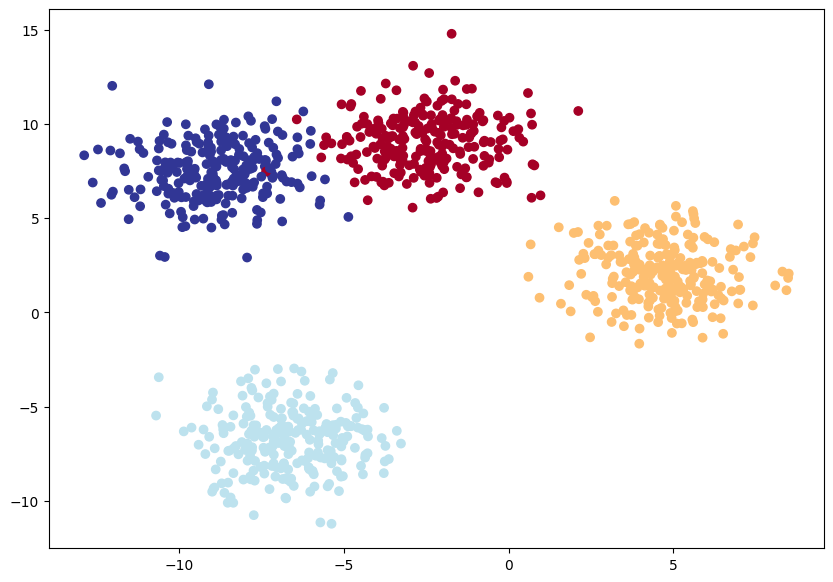

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

Let's create a subclass of `nn.Module` that takes in three hyperparameters:
- `input_features`: the number of $X$ features coming in
- `output_features`: the *ideal* number of output features we'd like to have
- `hidden_units`: the number of hidden neurons in the hidden layer

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Now let's create a loss function and an optimizer:

In [5]:
# Create loss function
loss_fn = nn.CrossEntropyLoss()
# Create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                              lr=0.1)

Let's perform a single forward pass to see how the model performs.

In [6]:
print(model_4(X_blob_train.to(device))[:5])

tensor([[ 1.0324,  0.2999, -0.2214, -0.7608],
        [ 0.4001,  0.1635, -0.6208,  0.2619],
        [-1.7492, -1.1318,  0.9030,  0.0315],
        [-1.0712, -0.7495,  0.5133, -0.0129],
        [ 0.1355,  0.0035, -0.4315,  0.2314]], grad_fn=<SliceBackward0>)


In [7]:
# Check the shape of the output
print(model_4(X_blob_train.to(device)).shape, NUM_CLASSES)

torch.Size([800, 4]) 4


Given the output, we can see that the model is predicting one value for each class.

Since these are logits, we need to use an activation function to convert them into probabilities.

In [8]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.0642,  0.3380, -0.3096, -0.6728],
        [-0.5417, -0.2891, -0.3515,  0.6734],
        [-1.3502, -0.9388,  0.7844, -0.1370],
        [ 0.6904,  0.1110, -0.0387, -0.7205],
        [ 0.7941,  0.3430, -0.6995,  0.0461]], grad_fn=<SliceBackward0>)
tensor([[0.5228, 0.2529, 0.1323, 0.0920],
        [0.1456, 0.1875, 0.1761, 0.4908],
        [0.0698, 0.1053, 0.5901, 0.2348],
        [0.4373, 0.2450, 0.2110, 0.1067],
        [0.4283, 0.2728, 0.0962, 0.2027]], grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [9]:
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in `y_pred_probs`, the index of the **highest** value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [10]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.5228, 0.2529, 0.1323, 0.0920], grad_fn=<SelectBackward0>)
tensor(0)


This means that for the features (x) of the sample at index 0, the model is predicting the most likely class value (y).

Let's create a training loop.

In [11]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [12]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.95324, Acc: 64.50% | Test Loss: 0.68310, Test Acc: 77.50%
Epoch: 10 | Loss: 0.19430, Acc: 99.12% | Test Loss: 0.16896, Test Acc: 99.00%
Epoch: 20 | Loss: 0.09482, Acc: 99.00% | Test Loss: 0.08442, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06632, Acc: 99.12% | Test Loss: 0.05778, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05347, Acc: 99.12% | Test Loss: 0.04527, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04631, Acc: 99.12% | Test Loss: 0.03810, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04180, Acc: 99.12% | Test Loss: 0.03349, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03873, Acc: 99.12% | Test Loss: 0.03029, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03651, Acc: 99.12% | Test Loss: 0.02794, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03485, Acc: 99.12% | Test Loss: 0.02614, Test Acc: 99.50%


Let's now check the model's predictions, which will be logits:

In [13]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
print(y_logits[:10])

tensor([[  8.0340,  13.4341,  -8.6681,  -5.2922],
        [  2.3480, -12.8966,   0.4851,   7.9912],
        [-13.5146, -19.5003,  14.3677,   5.7698],
        [  3.5563,   8.9195,  -4.2873,  -4.3619],
        [ 11.3794,   6.8044, -10.1976,  -0.1101],
        [  2.3113, -16.0951,   1.0720,   9.8564],
        [-13.1371, -15.9300,  13.4424,   3.8172],
        [  8.7169,   1.5080,  -7.1375,   1.9777],
        [-15.0854, -25.7562,  16.7188,   8.8412],
        [  9.5064,   3.3831,  -8.0980,   1.1796]])


Let's convert the model's prediction logits into prediction probabilities and then into prediction labels.

In [14]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


Let's visualize the model's decision boundaries.

In [15]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

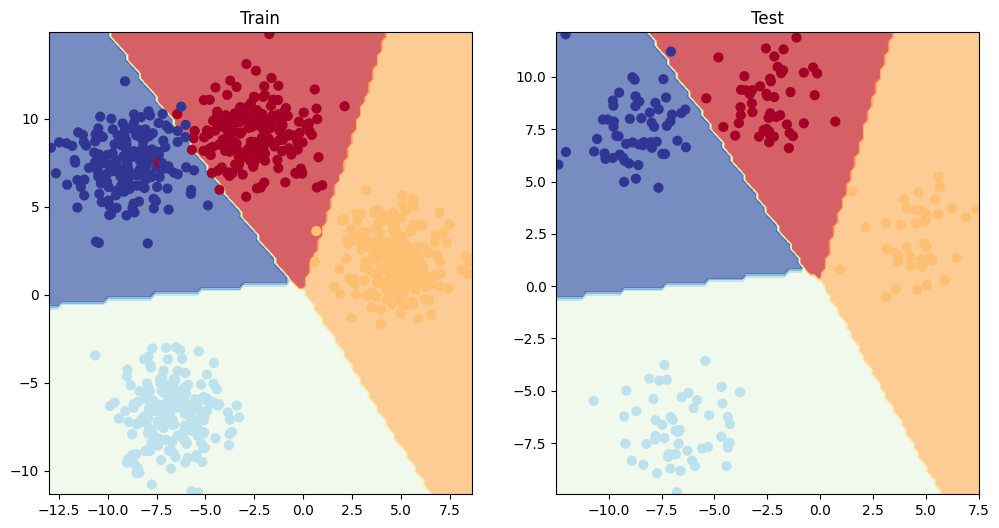

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

Let's see how to use the `torchmetrics` library to calculate accuracy

In [17]:
try:
    from torchmetrics import Accuracy
except ImportError as e:
    print("Please install torchmetrics to use this feature.")
    raise e
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)